In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
from src.styles import set_plot_style
from src.plots import *
from src.timeline import *
from src.utils import load_and_prepare_metadata
set_plot_style("prism_rain")
from src.utils import _proc_from_path, _file_index, _read_measurement
import polars as pl

saved figs/Encap68_IVg_sequence_Alisson_15_sept_metadata.png


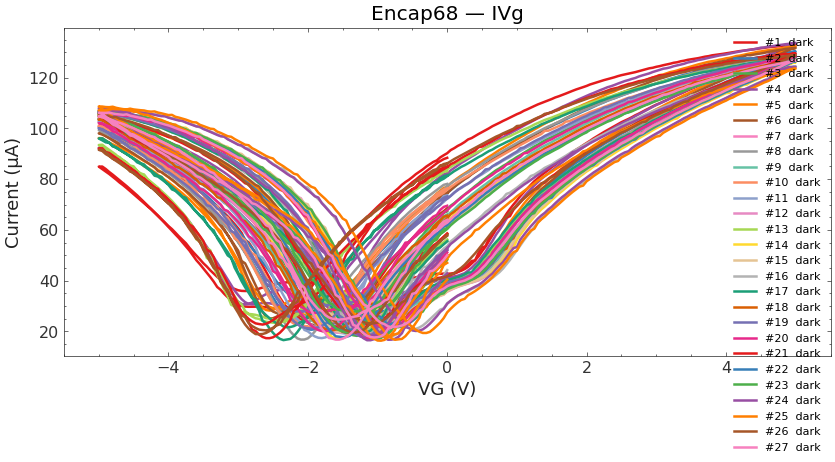

In [2]:
METADATA_CSV = "Alisson_15_sept_metadata.csv"        # path to the table you pasted
BASE_DIR     = Path("raw_data")             # where the raw CSVs live, e.g. "Alisson_04_sept/"
CHIP_NUMBER  = 68.0 
meta = load_and_prepare_metadata(METADATA_CSV, CHIP_NUMBER)
tag = Path(METADATA_CSV).stem


# Reuse your existing plotter on this subset
plot_ivg_sequence(meta, BASE_DIR, tag) 

In [3]:
def plot_ivg_unrolled_I_vs_t(
    df: pl.DataFrame,
    base_dir: Path,
    tag: str,
    *,
    line_freq_hz: float = 50.0,
    use_clock_if_available: bool = True,
    clip_t_min: float | None = None,
    show_legend: bool = False,
):
    # --- robust sort: prefer start_time, else session, else file_idx only ---
    sort_cols = [c for c in ("start_time", "session", "file_idx") if c in df.columns]
    if not sort_cols:
        sort_cols = ["file_idx"]  # absolute last resort

    ivg = df.filter(pl.col("proc") == "IVg").sort(sort_cols, nulls_last=True)
    if ivg.height == 0:
        print("[info] no IVg rows to plot")
        return

    def _derive_time_series_ivg(d: pl.DataFrame, row: dict) -> np.ndarray:
        # 1) file clock if present
        if use_clock_if_available:
            for cname in ("Clock", "Clock (ms)"):
                if cname in d.columns:
                    clk = d[cname].to_numpy()
                    if clk.size and np.isfinite(clk).any():
                        clk0 = np.nanmin(clk)
                        return (clk - clk0) / (1000.0 if "ms" in cname.lower() else 1.0)

        n = d.height

        # 2) metadata Step time (in seconds) if > 0
        step_time = None
        for k in ("Step time", "Step time (s)", "step_time", "Step time_meta"):
            if k in row and row[k] is not None:
                try:
                    step_time = float(row[k]); break
                except Exception:
                    pass
        if step_time and np.isfinite(step_time) and step_time > 0:
            return np.arange(n, dtype=float) * step_time

        # 3) estimate dt from NPLC/mains
        nplc = None
        for k in ("NPLC", "NPLC_meta"):
            if k in row and row[k] is not None:
                try:
                    nplc = float(row[k]); break
                except Exception:
                    pass
        if nplc and np.isfinite(nplc) and nplc > 0 and line_freq_hz > 0:
            dt = nplc / float(line_freq_hz)  # ~0.02 s @50 Hz when NPLC=1
            return np.arange(n, dtype=float) * dt

        # 4) fallback: 1 s/sample
        return np.arange(n, dtype=float)

    # set up a 2-row figure sharing time axis
    fig, (ax_vg, ax_i) = plt.subplots(
        nrows=2, ncols=1, sharex=True,
        gridspec_kw={"height_ratios": [1, 3]},
        figsize=(10, 6)
    )

    t_offset = 0.0
    curves = 0
    all_T = []
    warned_vg_missing = False

    # accepted gate voltage column name candidates
    vg_candidates = ("VG", "Vg", "Vg (V)", "VG (V)", "Gate", "Gate (V)", "V_G", "Vgate")

    for row in ivg.iter_rows(named=True):
        path = base_dir / row["source_file"]
        if not path.exists():
            print(f"[warn] missing file: {path}"); continue

        d = _read_measurement(path)

        # --- pull columns ---
        if "I" not in d.columns:
            print(f"[warn] {path} lacks 'I'; got {d.columns}"); continue

        vg_col = next((c for c in vg_candidates if c in d.columns), None)
        if vg_col is None and not warned_vg_missing:
            print(f"[warn] no gate-voltage column found in {path}; tried {vg_candidates}")
            warned_vg_missing = True

        # --- derive time & extract series ---
        t = _derive_time_series_ivg(d, row)
        I = d["I"].to_numpy()
        VG = d[vg_col].to_numpy() if vg_col else None

        # --- optional clip ---
        if clip_t_min is not None:
            m = t >= float(clip_t_min)
            t, I = t[m], I[m]
            if VG is not None:
                VG = VG[m]

        lbl = f"#{int(row['file_idx'])}  {'light' if row.get('with_light', False) else 'dark'}"

        if t.size:
            t0 = t[0]
            t = t - t0
            all_T.append(t[-1])
            ax_i.plot(t, I * 1e6, label=lbl, color='k')
            if VG is not None:
                ax_vg.plot(t, VG, label=lbl, color = 'k')

        curves += 1

    if curves == 0:
        print("[warn] no IVg curves plotted as I(t)")
        plt.close(fig)
        return

    # --- labels, limits, cosmetics ---
    ax_vg.set_ylabel(r"$V_G$ (V)")
    ax_i.set_ylabel("Current (µA)")
    ax_i.set_xlabel("Time (s)")

    title_chip = f"Encap{int(df['Chip number'][0])}" if 'Chip number' in df.columns else "Chip"
    fig.suptitle(f"{title_chip} — IVg as I(t) with $V_G(t)$", y=0.98)

    Tmax = float(np.nanmedian(all_T))
    if np.isfinite(Tmax) and Tmax > 0:
        t0 = float(clip_t_min) if clip_t_min else 0.0
        ax_i.set_xlim(t0, Tmax)

    #ax_vg.grid(True, alpha=0.25)
    #ax_i.grid(True, alpha=0.25)

    if show_legend:
        ax_i.legend(fontsize=8, loc="best")

    plt.tight_layout()
    suffix = "_IVg_I_vs_t_overlay_with_VG"
    out = FIG_DIR / f"{title_chip}{suffix}_{tag}.png"
    fig.savefig(out, dpi=300)
    plt.plot()
    print(f"saved {out}")


saved figs/Encap68_IVg_I_vs_t_overlay_with_VG_Alisson_15_sept_metadata.png


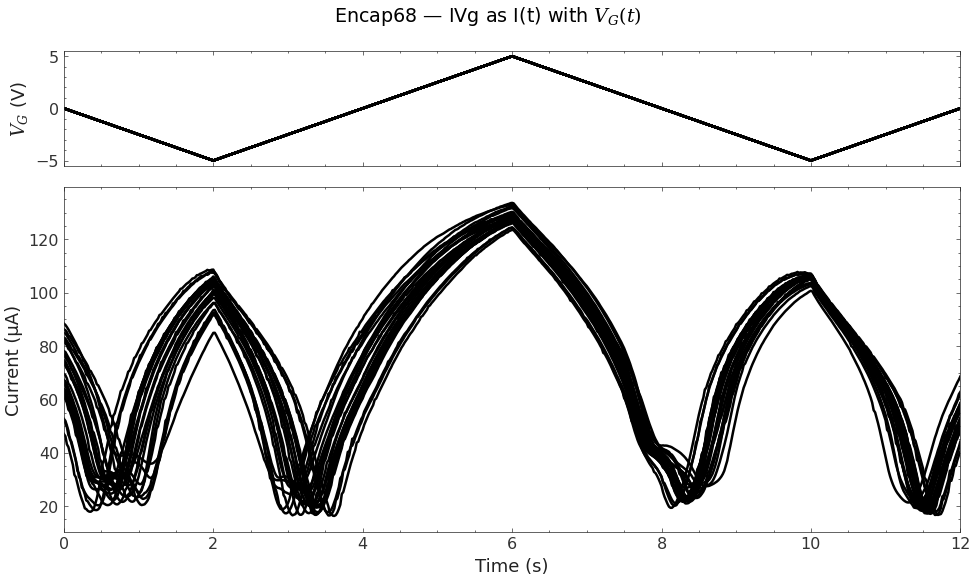

In [4]:
plot_ivg_unrolled_I_vs_t(meta, BASE_DIR, tag, clip_t_min=0)

saved figs/Encap68_IVg_I_vs_t_overlay_with_VG_Alisson_15_sept_metadata.png


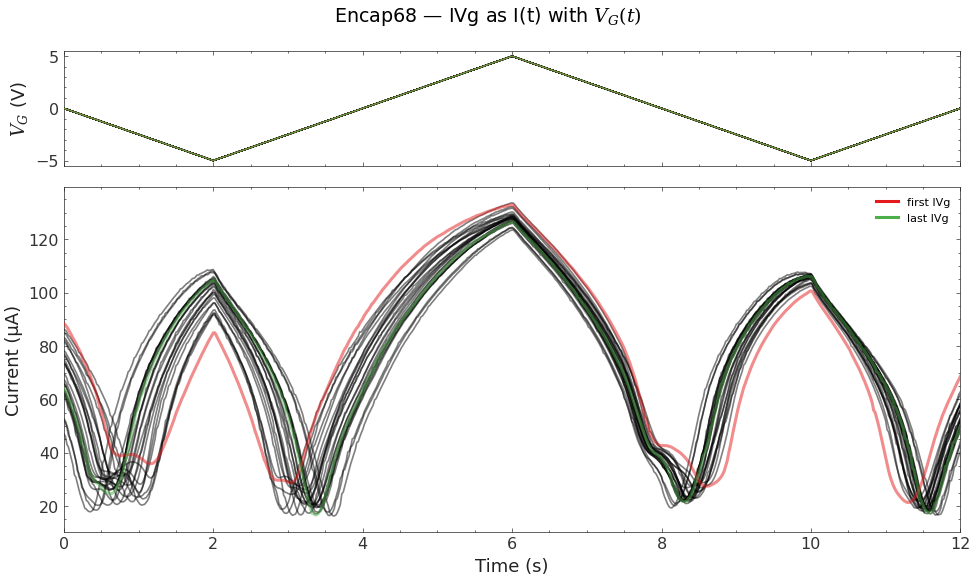

In [5]:
def plot_ivg_unrolled_I_vs_t(
    df: pl.DataFrame,
    base_dir: Path,
    tag: str,
    *,
    line_freq_hz: float = 50.0,
    use_clock_if_available: bool = True,
    clip_t_min: float | None = None,
    show_legend: bool = False,
):
    # --- robust sort: prefer start_time, else session, else file_idx only ---
    sort_cols = [c for c in ("start_time", "session", "file_idx") if c in df.columns]
    if not sort_cols:
        sort_cols = ["file_idx"]  # absolute last resort

    ivg = df.filter(pl.col("proc") == "IVg").sort(sort_cols, nulls_last=True)
    if ivg.height == 0:
        print("[info] no IVg rows to plot")
        return

    def _derive_time_series_ivg(d: pl.DataFrame, row: dict) -> np.ndarray:
        # 1) file clock if present
        if use_clock_if_available:
            for cname in ("Clock", "Clock (ms)"):
                if cname in d.columns:
                    clk = d[cname].to_numpy()
                    if clk.size and np.isfinite(clk).any():
                        clk0 = np.nanmin(clk)
                        return (clk - clk0) / (1000.0 if "ms" in cname.lower() else 1.0)

        n = d.height

        # 2) metadata Step time (in seconds) if > 0
        step_time = None
        for k in ("Step time", "Step time (s)", "step_time", "Step time_meta"):
            if k in row and row[k] is not None:
                try:
                    step_time = float(row[k]); break
                except Exception:
                    pass
        if step_time and np.isfinite(step_time) and step_time > 0:
            return np.arange(n, dtype=float) * step_time

        # 3) estimate dt from NPLC/mains
        nplc = None
        for k in ("NPLC", "NPLC_meta"):
            if k in row and row[k] is not None:
                try:
                    nplc = float(row[k]); break
                except Exception:
                    pass
        if nplc and np.isfinite(nplc) and nplc > 0 and line_freq_hz > 0:
            dt = nplc / float(line_freq_hz)  # ~0.02 s @50 Hz when NPLC=1
            return np.arange(n, dtype=float) * dt

        # 4) fallback: 1 s/sample
        return np.arange(n, dtype=float)

    # set up a 2-row figure sharing time axis
    fig, (ax_vg, ax_i) = plt.subplots(
        nrows=2, ncols=1, sharex=True,
        gridspec_kw={"height_ratios": [1, 3]},
        figsize=(10, 6)
    )

    all_T = []
    warned_vg_missing = False
    vg_candidates = ("VG", "Vg", "Vg (V)", "VG (V)", "Gate", "Gate (V)", "V_G", "Vgate")

    # ---------------------------
    # First pass: collect entries
    # ---------------------------
    entries = []
    for row in ivg.iter_rows(named=True):
        path = base_dir / row["source_file"]
        if not path.exists():
            print(f"[warn] missing file: {path}")
            continue

        d = _read_measurement(path)

        if "I" not in d.columns:
            print(f"[warn] {path} lacks 'I'; got {d.columns}")
            continue

        vg_col = next((c for c in vg_candidates if c in d.columns), None)
        if vg_col is None and not warned_vg_missing:
            print(f"[warn] no gate-voltage column found in {path}; tried {vg_candidates}")
            warned_vg_missing = True

        t = _derive_time_series_ivg(d, row)
        I = d["I"].to_numpy()
        VG = d[vg_col].to_numpy() if vg_col else None

        if clip_t_min is not None:
            m = t >= float(clip_t_min)
            t, I = t[m], I[m]
            if VG is not None:
                VG = VG[m]

        if t.size == 0:
            continue

        # normalize time to start at zero
        t = t - t[0]
        lbl = f"#{int(row['file_idx'])}  {'light' if row.get('with_light', False) else 'dark'}"

        entries.append({"t": t, "I": I, "VG": VG, "label": lbl})

    if not entries:
        print("[warn] no IVg curves plotted as I(t)")
        plt.close(fig)
        return

    # ---------------------------
    # Second pass: plot with colors
    # ---------------------------
    n = len(entries)
    first_idx = 0
    last_idx = n - 1

    first_color = "#e41a1c"  # HIGHLIGHT: first
    last_color  = "#4daf4a"    # HIGHLIGHT: last
    other_color = "k"

    for i, e in enumerate(entries):
        color = other_color
        lw = 1.2
        z = 2
        if n == 1:
            color, lw, z = first_color, 2.2, 3
        else:
            if i == first_idx:
                color, lw, z = first_color, 2.2, 3
            elif i == last_idx:
                color, lw, z = last_color, 2.2, 3

        t, I, VG, lbl = e["t"], e["I"], e["VG"], e["label"]
        all_T.append(t[-1])
        ax_i.plot(t, I * 1e6, label=lbl, color=color, lw=lw, alpha=0.5, zorder=z)
        if VG is not None:
            ax_vg.plot(t, VG, color=color, lw=1, alpha=0.9, zorder=z)

    # --- labels, limits, cosmetics ---
    ax_vg.set_ylabel(r"$V_G$ (V)")
    ax_i.set_ylabel("Current (µA)")
    ax_i.set_xlabel("Time (s)")

    title_chip = f"Encap{int(df['Chip number'][0])}" if 'Chip number' in df.columns else "Chip"
    fig.suptitle(f"{title_chip} — IVg as I(t) with $V_G(t)$", y=0.98)

    Tmax = float(np.nanmedian(all_T))
    if np.isfinite(Tmax) and Tmax > 0:
        t0 = float(clip_t_min) if clip_t_min else 0.0
        ax_i.set_xlim(t0, Tmax)

    # Add a tiny legend key for what the colors mean (optional)
    # You can comment this out if you prefer the original legend behavior.
    from matplotlib.lines import Line2D
    legend_handles = [
        Line2D([0], [0], color=first_color, lw=2.2, label="first IVg"),
        Line2D([0], [0], color=last_color, lw=2.2, label="last IVg"),
    ]
    if show_legend:
        # show curve labels too
        ax_i.legend(fontsize=8, loc="best")
        ax_i.add_artist(ax_i.legend(handles=legend_handles, loc="upper right", fontsize=8))
    else:
        # at least show the color meaning
        ax_i.legend(handles=legend_handles, loc="upper right", fontsize=8)

    plt.tight_layout()
    suffix = "_IVg_I_vs_t_overlay_with_VG"
    out = FIG_DIR / f"{title_chip}{suffix}_{tag}.png"
    fig.savefig(out, dpi=300)
    plt.plot()
    print(f"saved {out}")

plot_ivg_unrolled_I_vs_t(meta, BASE_DIR, tag, clip_t_min=0)

In [15]:
from matplotlib.lines import Line2D
from matplotlib import patheffects as pe

def plot_ivg_unrolled_I_vs_t(
    df: pl.DataFrame,
    base_dir: Path,
    tag: str,
    *,
    line_freq_hz: float = 50.0,
    use_clock_if_available: bool = True,
    clip_t_min: float | None = None,
    show_legend: bool = False,
):
    # --- robust sort: prefer start_time, else session, else file_idx only ---
    sort_cols = [c for c in ("start_time", "session", "file_idx") if c in df.columns]
    if not sort_cols:
        sort_cols = ["file_idx"]  # absolute last resort

    ivg = df.filter(pl.col("proc") == "IVg").sort(sort_cols, nulls_last=True)
    if ivg.height == 0:
        print("[info] no IVg rows to plot")
        return

    def _derive_time_series_ivg(d: pl.DataFrame, row: dict) -> np.ndarray:
        # 1) file clock if present
        if use_clock_if_available:
            for cname in ("Clock", "Clock (ms)"):
                if cname in d.columns:
                    clk = d[cname].to_numpy()
                    if clk.size and np.isfinite(clk).any():
                        clk0 = np.nanmin(clk)
                        return (clk - clk0) / (1000.0 if "ms" in cname.lower() else 1.0)

        n = d.height

        # 2) metadata Step time (in seconds) if > 0
        step_time = None
        for k in ("Step time", "Step time (s)", "step_time", "Step time_meta"):
            if k in row and row[k] is not None:
                try:
                    step_time = float(row[k]); break
                except Exception:
                    pass
        if step_time and np.isfinite(step_time) and step_time > 0:
            return np.arange(n, dtype=float) * step_time

        # 3) estimate dt from NPLC/mains
        nplc = None
        for k in ("NPLC", "NPLC_meta"):
            if k in row and row[k] is not None:
                try:
                    nplc = float(row[k]); break
                except Exception:
                    pass
        if nplc and np.isfinite(nplc) and nplc > 0 and line_freq_hz > 0:
            dt = nplc / float(line_freq_hz)  # ~0.02 s @50 Hz when NPLC=1
            return np.arange(n, dtype=float) * dt

        # 4) fallback: 1 s/sample
        return np.arange(n, dtype=float)

    # set up a 2-row figure sharing time axis
    fig, (ax_vg, ax_i) = plt.subplots(
        nrows=2, ncols=1, sharex=True,
        gridspec_kw={"height_ratios": [1, 3]},
        figsize=(10, 6)
    )

    all_T = []
    warned_vg_missing = False
    vg_candidates = ("VG", "Vg", "Vg (V)", "VG (V)", "Gate", "Gate (V)", "V_G", "Vgate")

    # ---------------------------
    # First pass: collect entries
    # ---------------------------
    entries = []
    for row in ivg.iter_rows(named=True):
        path = base_dir / row["source_file"]
        if not path.exists():
            print(f"[warn] missing file: {path}")
            continue

        d = _read_measurement(path)

        if "I" not in d.columns:
            print(f"[warn] {path} lacks 'I'; got {d.columns}")
            continue

        vg_col = next((c for c in vg_candidates if c in d.columns), None)
        if vg_col is None and not warned_vg_missing:
            print(f"[warn] no gate-voltage column found in {path}; tried {vg_candidates}")
            warned_vg_missing = True

        t = _derive_time_series_ivg(d, row)
        I = d["I"].to_numpy()
        VG = d[vg_col].to_numpy() if vg_col else None

        if clip_t_min is not None:
            m = t >= float(clip_t_min)
            t, I = t[m], I[m]
            if VG is not None:
                VG = VG[m]

        if t.size == 0:
            continue

        # normalize time to start at zero
        t = t - t[0]
        lbl = f"#{int(row['file_idx'])}  {'light' if row.get('with_light', False) else 'dark'}"
        entries.append({"t": t, "I": I, "VG": VG, "label": lbl})

    if not entries:
        print("[warn] no IVg curves plotted as I(t)")
        plt.close(fig)
        return

    # ---------------------------
    # Second pass: plot with emphasis
    # ---------------------------
    n = len(entries)
    first_idx = 0
    last_idx = n - 1

    first_color = "#e41a1c"   # red
    last_color  = "#4daf4a"   # green
    other_color = "#808080"   # mid gray

    # thin, de-emphasized “others”
    other_style_i  = dict(color=other_color, lw=0.9, alpha=0.5, zorder=1)
    other_style_vg = dict(color=other_color, lw=0.8, alpha=0.5, zorder=1, ls=":")

    # path effect for glow around highlights (helps over dense overlays)
    glow = [pe.Stroke(linewidth=4.0, foreground="white", alpha=0.9), pe.Normal()]

    # plot “others” first so highlights sit on top
    for i, e in enumerate(entries):
        if n > 1 and i in (first_idx, last_idx):
            continue
        t, I, VG = e["t"], e["I"], e["VG"]
        all_T.append(t[-1])
        ax_i.plot(t, I * 1e6, **other_style_i)
        if VG is not None:
            ax_vg.plot(t, VG, **other_style_vg)

    # helper to plot a highlighted trace with glow + markers at ends
    def plot_highlight(t, y_i, y_vg, color, label_text):
        li, = ax_i.plot(t, y_i * 1e6, color=color, lw=2.6, alpha=0.95, zorder=4)
        li.set_path_effects(glow)
        if y_vg is not None:
            lv, = ax_vg.plot(t, y_vg, color=color, lw=2.0, alpha=0.95, zorder=4)
            lv.set_path_effects(glow)
        # small end markers + annotations (both panels)
        ax_i.plot([t[0], t[-1]], [y_i[0]*1e6, y_i[-1]*1e6], marker="o", ms=3, mec="none", mfc=color, ls="None", zorder=5)
        ax_i.annotate(label_text, xy=(t[-1], y_i[-1]*1e6), xytext=(6, 0),
                      textcoords="offset points", va="center", color=color, fontsize=9,
                      path_effects=[pe.withStroke(linewidth=3, foreground="white")])
        if y_vg is not None:
            ax_vg.plot([t[0], t[-1]], [y_vg[0], y_vg[-1]], marker="o", ms=3, mec="none", mfc=color, ls="None", zorder=5)
            ax_vg.annotate(label_text, xy=(t[-1], y_vg[-1]), xytext=(6, 0),
                           textcoords="offset points", va="center", color=color, fontsize=9,
                           path_effects=[pe.withStroke(linewidth=3, foreground="white")])

    # plot first
    t0, I0, VG0 = entries[first_idx]["t"], entries[first_idx]["I"], entries[first_idx]["VG"]
    all_T.append(t0[-1])
    plot_highlight(t0, I0, VG0, first_color, "first")

    # plot last (if distinct)
    if last_idx != first_idx:
        tL, IL, VGL = entries[last_idx]["t"], entries[last_idx]["I"], entries[last_idx]["VG"]
        all_T.append(tL[-1])
        plot_highlight(tL, IL, VGL, last_color, "last")

    # --- labels, limits, cosmetics ---
    ax_vg.set_ylabel(r"$V_G$ (V)")
    ax_i.set_ylabel("Current (µA)")
    ax_i.set_xlabel("Time (s)")

    title_chip = f"Encap{int(df['Chip number'][0])}" if 'Chip number' in df.columns else "Chip"
    fig.suptitle(f"{title_chip} — IVg as I(t) with $V_G(t)$", y=0.98)

    Tmax = float(np.nanmedian(all_T))
    if np.isfinite(Tmax) and Tmax > 0:
        t0 = float(clip_t_min) if clip_t_min else 0.0
        ax_i.set_xlim(t0, Tmax)


    # compact legend that only encodes meaning of colors
    legend_handles = [
        Line2D([0], [0], color=first_color, lw=2.6, label="first IVg"),
        Line2D([0], [0], color=last_color,  lw=2.6, label="last IVg"),
        Line2D([0], [0], color=other_color, lw=1.2, alpha=0.4, label="others"),
    ]
    if show_legend:
        ax_i.legend(handles=legend_handles, fontsize=8, loc="upper right", frameon=True)
    # else: keep uncluttered

    plt.tight_layout()
    suffix = "_IVg_I_vs_t_overlay_with_VG"
    out = FIG_DIR / f"{title_chip}{suffix}_{tag}.png"
    plt.plot()
    fig.savefig(out, dpi=300)
    print(f"saved {out}")

plot_ivg_unrolled_I_vs_t(meta, BASE_DIR, tag, clip_t_min=0)

saved figs/Encap68_IVg_I_vs_t_overlay_with_VG_Alisson_22_sept_metadata.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import patheffects as pe

def plot_ivg_unrolled_I_polar_only(
    df: pl.DataFrame,
    base_dir: Path,
    tag: str,
    *,
    line_freq_hz: float = 50.0,
    use_clock_if_available: bool = True,
    clip_t_min: float | None = None,
    show_legend: bool = False,
):
    # --- robust sort: prefer start_time, else session, else file_idx only ---
    sort_cols = [c for c in ("start_time", "session", "file_idx") if c in df.columns]
    if not sort_cols:
        sort_cols = ["file_idx"]

    ivg = df.filter(pl.col("proc") == "IVg").sort(sort_cols, nulls_last=True)
    if ivg.height == 0:
        print("[info] no IVg rows to plot")
        return

    def _derive_time_series_ivg(d: pl.DataFrame, row: dict) -> np.ndarray:
        # 1) clock column
        if use_clock_if_available:
            for cname in ("Clock", "Clock (ms)"):
                if cname in d.columns:
                    clk = d[cname].to_numpy()
                    if clk.size and np.isfinite(clk).any():
                        clk0 = np.nanmin(clk)
                        return (clk - clk0) / (1000.0 if "ms" in cname.lower() else 1.0)
        n = d.height
        # 2) step time from metadata
        for k in ("Step time", "Step time (s)", "step_time", "Step time_meta"):
            if k in row and row[k] is not None:
                try:
                    st = float(row[k])
                    if np.isfinite(st) and st > 0:
                        return np.arange(n, dtype=float) * st
                except Exception:
                    pass
        # 3) estimate from NPLC/mains
        for k in ("NPLC", "NPLC_meta"):
            if k in row and row[k] is not None and line_freq_hz > 0:
                try:
                    nplc = float(row[k])
                    if np.isfinite(nplc) and nplc > 0:
                        dt = nplc / float(line_freq_hz)
                        return np.arange(n, dtype=float) * dt
                except Exception:
                    pass
        # 4) fallback
        return np.arange(n, dtype=float)

    # -------- collect entries & global ranges --------
    entries = []
    Tmax_candidates, I_abs_max_candidates = [], []

    for row in ivg.iter_rows(named=True):
        path = base_dir / row["source_file"]
        if not path.exists():
            print(f"[warn] missing file: {path}")
            continue
        d = _read_measurement(path)
        if "I" not in d.columns:
            print(f"[warn] {path} lacks 'I'; got {d.columns}")
            continue

        t = _derive_time_series_ivg(d, row)
        I = d["I"].to_numpy()

        if clip_t_min is not None:
            m = t >= float(clip_t_min)
            t, I = t[m], I[m]

        if t.size == 0:
            continue

        t = t - t[0]  # start at zero
        Tmax_candidates.append(t[-1])
        if np.isfinite(I).any():
            I_abs_max_candidates.append(np.nanmax(np.abs(I)))

        lbl = f"#{int(row['file_idx'])}  {'light' if row.get('with_light', False) else 'dark'}"
        entries.append({"t": t, "I": I, "label": lbl})

    if not entries:
        print("[warn] no IVg curves to plot")
        return

    Tmax = float(np.nanmax(Tmax_candidates)) if Tmax_candidates else 0.0
    if not np.isfinite(Tmax) or Tmax <= 0:
        print("[warn] invalid total time; cannot make polar mapping")
        return

    I_abs_max = float(np.nanmax(I_abs_max_candidates)) if I_abs_max_candidates else 1.0
    if not np.isfinite(I_abs_max) or I_abs_max <= 0:
        I_abs_max = 1.0

    TWO_PI = 2.0 * np.pi
    for e in entries:
        e["theta"] = (e["t"] / Tmax) * TWO_PI
        e["r"] = np.abs(e["I"]) / I_abs_max  # normalized, unitless

    # -------- plot (single polar figure) --------
    fig = plt.figure(figsize=(8.5, 7))
    ax = fig.add_subplot(111, projection="polar")

    n = len(entries)
    first_idx, last_idx = 0, n - 1

    first_color = "#e41a1c"   # red
    last_color  = "#4daf4a"   # green
    other_color = "#808080"   # gray

    other_style = dict(color=other_color, lw=0.9, alpha=0.5, zorder=1)
    glow = [pe.Stroke(linewidth=4.0, foreground="white", alpha=0.9), pe.Normal()]

    # others
    for i, e in enumerate(entries):
        if n > 1 and i in (first_idx, last_idx):
            continue
        ax.plot(e["theta"], e["r"], **other_style)

    # helper for highlights
    def plot_highlight(e, color, label_text):
        li, = ax.plot(e["theta"], e["r"], color=color, lw=2.6, alpha=0.95, zorder=3)
        li.set_path_effects(glow)
        ax.plot([e["theta"][-1]], [e["r"][-1]], marker="o", ms=3, mec="none", mfc=color, zorder=4)
        ax.annotate(label_text, xy=(e["theta"][-1], e["r"][-1]), xytext=(6, 0),
                    textcoords="offset points", va="center", color=color, fontsize=9,
                    path_effects=[pe.withStroke(linewidth=3, foreground="white")])

    plot_highlight(entries[first_idx], first_color, "first")
    if last_idx != first_idx:
        plot_highlight(entries[last_idx],  last_color,  "last")

    # cosmetics
    ax.set_title("I(θ) — polar view (|I| normalized; time → angle)", pad=12)
    ax.set_rlim(0.0, 1.02)
    ax.set_rlabel_position(135)

    legend_handles = [
        Line2D([0], [0], color=first_color, lw=2.6, label="first IVg"),
        Line2D([0], [0], color=last_color,  lw=2.6, label="last IVg"),
        Line2D([0], [0], color=other_color, lw=1.2, alpha=0.4, label="others"),
    ]
    if show_legend:
        ax.legend(handles=legend_handles, fontsize=8, loc="upper right", frameon=True)

    title_chip = f"Encap{int(df['Chip number'][0])}" if 'Chip number' in df.columns else "Chip"
    suffix = "_IVg_polar_I_theta_ONLY"
    out = FIG_DIR / f"{title_chip}{suffix}_{tag}.png"
    plt.tight_layout()
    fig.savefig(out, dpi=300)
    print(f"saved {out}")

plot_ivg_unrolled_I_polar_only(meta, BASE_DIR, tag, clip_t_min=0)

saved figs/Encap68_IVg_sequence_Alisson_15_sept_metadata.png


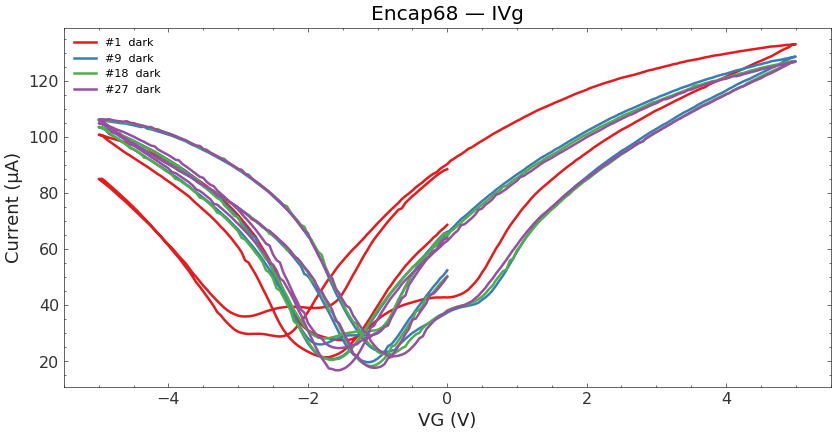

In [7]:
good_ivgs = [1,9,18,27]  # the _NN.csv numbers you want

meta_only_good_ivg = meta.filter(
    (pl.col("proc") == "IVg") & pl.col("file_idx").is_in(good_ivgs)
)

# Reuse your existing plotter on this subset
plot_ivg_sequence(meta_only_good_ivg, BASE_DIR, tag) 

In [8]:
# after you already built your per-chip `meta`:
ivg_sequence_gif(meta, BASE_DIR, tag, fps=2, cumulative=True)
# or cumulative overlay:
#ivg_sequence_gif(meta, BASE_DIR, tag, fps=2.0, cumulative=True)

saved figs/Encap68_IVg_sequence_Alisson_15_sept_metadata.gif


In [9]:
METADATA_CSV = "metadata/Alisson_15_sept/metadata.csv"        # path to the table you pasted
BASE_DIR     = Path(".")             # where the raw CSVs live, e.g. "Alisson_04_sept/"
CHIP_NUMBER  = 68.0 
meta = load_and_prepare_metadata(METADATA_CSV, CHIP_NUMBER)
tag = Path(METADATA_CSV).stem


plot_its_by_vg_delta(
    meta, BASE_DIR, tag,
    baseline_t=60.0, clip_t_min=20.0
)

[info] no ITS rows for Vg≈-6.02 V, λ≈365 nm
saved figs/chip68_ITS_dI_Vgm6p02_385nm_metadata.png
[info] no ITS rows for Vg≈-6.02 V, λ≈405 nm
[info] no ITS rows for Vg≈-6.02 V, λ≈455 nm
[info] no ITS rows for Vg≈-6.02 V, λ≈505 nm
[info] no ITS rows for Vg≈-6.02 V, λ≈565 nm
[info] no ITS rows for Vg≈-6.02 V, λ≈590 nm
[info] no ITS rows for Vg≈-6.02 V, λ≈625 nm
[info] no ITS rows for Vg≈-6.02 V, λ≈680 nm
[info] no ITS rows for Vg≈-6.02 V, λ≈850 nm
saved figs/chip68_ITS_dI_Vgm5p81_365nm_metadata.png
[info] no ITS rows for Vg≈-5.81 V, λ≈385 nm
[info] no ITS rows for Vg≈-5.81 V, λ≈405 nm
[info] no ITS rows for Vg≈-5.81 V, λ≈455 nm
[info] no ITS rows for Vg≈-5.81 V, λ≈505 nm
[info] no ITS rows for Vg≈-5.81 V, λ≈565 nm
[info] no ITS rows for Vg≈-5.81 V, λ≈590 nm
[info] no ITS rows for Vg≈-5.81 V, λ≈625 nm
[info] no ITS rows for Vg≈-5.81 V, λ≈680 nm
[info] no ITS rows for Vg≈-5.81 V, λ≈850 nm
[info] no ITS rows for Vg≈-5.77 V, λ≈365 nm
[info] no ITS rows for Vg≈-5.77 V, λ≈385 nm
[info] no ITS ro

In [10]:
BASE = Path(".")
CSV  = "Alisson_22_sept_metadata.csv"
timeline = print_day_timeline(CSV, BASE)


=== Day timeline (chronological) ===
  1  11:28:58  IVg chip 68  VDS=0.1 V  VG:-5.0→5.0 (step 0.05)  #1
  2  11:35:10  LaserCalibration λ=365.0 nm  #1
  3  11:49:25  IVg chip 68  VDS=0.1 V  VG:-5.0→5.0 (step 0.05)  #2
  4  11:52:06  It  chip 68  VG=-5.46 V  VDS=0.1 V  VL=0.89 V  λ=365.0 nm  period=240.0 s  #1
  5  11:58:09  It  chip 68  VG=-5.46 V  VDS=0.1 V  VL=2.77 V  λ=365.0 nm  period=240.0 s  #2
  6  12:04:09  It  chip 68  VG=-5.46 V  VDS=0.1 V  VL=4.76 V  λ=365.0 nm  period=240.0 s  #3
  7  12:10:10  It  chip 68  VG=-5.46 V  VDS=0.1 V  VL=0.89 V  λ=365.0 nm  period=240.0 s  #4
  8  12:16:10  It  chip 68  VG=-5.46 V  VDS=0.1 V  VL=2.77 V  λ=365.0 nm  period=240.0 s  #5
  9  12:22:10  It  chip 68  VG=-5.46 V  VDS=0.1 V  VL=4.76 V  λ=365.0 nm  period=240.0 s  #6
 10  12:39:29  It  chip 68  VG=-5.46 V  VDS=0.1 V  VL=0.89 V  λ=365.0 nm  period=240.0 s  #7
 11  12:48:47  It  chip 68  VG=-5.46 V  VDS=0.1 V  VL=2.77 V  λ=365.0 nm  period=240.0 s  #8
 12  12:54:47  It  chip 68  VG=-5.46 

In [11]:

plot_its_wavelength_overlay_delta_for_chip(
    meta, BASE_DIR, tag,
    chip=68,
    vg_center=-5.0, vg_window=1.5,     # your VG varies a bit in the timeline
    wavelengths=None,                   # None => use all wavelengths present
    baseline_t=60.0, clip_t_min=40.0
)

plot_its_wavelength_overlay_delta_for_chip(
    meta, BASE_DIR, tag,
    chip=68,
    vg_center=-5.0, vg_window=1.5,     # your VG varies a bit in the timeline
    wavelengths=[365.0,385.0,405.0,455.0],                   # None => use all wavelengths present
    baseline_t=60.0, clip_t_min=40.0
)

plot_its_wavelength_overlay_delta_for_chip(
    meta, BASE_DIR, tag,
    chip=68,
    vg_center=-5.0, vg_window=1.5,     # your VG varies a bit in the timeline
    wavelengths=[505.0,565.0,590.0,625.0,680.0,850.0],                   # None => use all wavelengths present
    baseline_t=60.0, clip_t_min=40.0
)

saved figs/Chip68_ITS_dI_vs_wavelength_metadata.png
saved figs/Chip68_ITS_dI_vs_wavelength_metadata.png
saved figs/Chip68_ITS_dI_vs_wavelength_metadata.png


In [12]:
METADATA_CSV = "Alisson_22_sept_metadata.csv"        # path to the table you pasted
BASE_DIR     = Path(".")             # where the raw CSVs live, e.g. "Alisson_04_sept/"
CHIP_NUMBER  = 68.0 
meta = load_and_prepare_metadata(METADATA_CSV, CHIP_NUMBER)
tag = Path(METADATA_CSV).stem

ivg_sequence_gif(meta, BASE_DIR, tag, fps=2, cumulative=True)
plot_its_by_vg_delta(
    meta, BASE_DIR, tag,
    baseline_t=120, clip_t_min=20.0
)


saved figs/Encap68_IVg_sequence_Alisson_22_sept_metadata.gif
saved figs/chip68_ITS_dI_Vgm5p46_365nm_Alisson_22_sept_metadata.png
saved figs/chip68_ITS_dI_Vg1p16_365nm_Alisson_22_sept_metadata.png
